In [363]:
import json
import pandas as pd
import statistics as stats
import re
import pprint

In [364]:
import matplotlib.pyplot as plt

In [365]:
ALL_TABULAR_DATASETS = ["adult", "census", "child", "covtype", "credit", "insurance", "health_insurance", 
                       "intrusion", "drugs", "loan", "pums"]
ALL_TABULAR_MODELS = {
    "gretel": ["actgan"], 
    "sdv": ["ctgan", "tvae", "gaussian_copula"], 
    "synthcity": ["ctgan", "tvae", "goggle", "arf", "ddpm", "nflow", "rtvae"], 
    "llm": ["great"], 
    "betterdata": ["gan", "gan_dp"],
    "hpo_synthcity": ["arf", "ctgan", "ddpm", "rtvae", "tvae"]
}

ALL_SEQUENTIAL_DATASETS = ["taxi", "nasdaq", "pums"]

ALL_SEQUENTIAL_MODELS = {
    "gretel": ["dgan"],
    "sdv": ["par"]
}

# EXECUTION IS DONE ON DIFFERENT RESOURCES

# Performance Evaluation

In [366]:
ERROR_VAL  = -99
def get_execution_scores_df(exp_dataset, case="tabular"):
    
    final_report = {
        "dataset": [],
        "lib": [], 
        "model": [],
        "num_rows": [], 
        "num_cols": [], 
        "num_sampled_rows": [],
        "device": [],
        "num_epochs": [], 
        "train_time_sec": [],
        "sample_time_sec": [], 
        "peak_memory_mb": [], 
        "synthesizer_size": [],
        "synthetic_dataset_size_mb_deep": [], 
        "train_dataset_size_mb_deep": [], 
        "synthetic_dataset_size_mb": [],
        "train_dataset_size_mb": []
    }
    
    for lib, models in ALL_TABULAR_MODELS.items():
        
        for model in models: 
            
            BASE = f"final_outs/{lib}_tabular"
            execution_scores_path = f"../{BASE}/{model}/{exp_dataset}/{exp_dataset}_{model}_execution_scores.json"
            
            try:
                with open(execution_scores_path, 'r') as file:
                    execution_scores = json.load(file)
            except Exception as e:
                # print(e)
                continue
                      
            # corr_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_correlation.csv"
            # metrics_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_metrics.json"
            final_report["model"].append(f"{model}_{lib}")
            for k, v in final_report.items():
                if k in ["model"]: continue # "modality", "synthesizer"
                
                if k not in execution_scores:
                    final_report[k].append("-99")
                    continue
                final_report[k].append(execution_scores[k])
                    
# execution_scores
    # for k, v in final_report.items():
    #     print(k, len(v))
                    
    return final_report

In [367]:
execution_scores_df["device"].unique()

array(['GPU', 'CPU', 'cpu', '-99', 'cuda'], dtype=object)

In [368]:
execution_scores_df = pd.DataFrame()
for exp_dataset in ALL_TABULAR_DATASETS:
    final_report = get_execution_scores_df(exp_dataset, case="tabular")
    execution_scores_df = pd.concat([execution_scores_df, pd.DataFrame(final_report)], ignore_index=True)
execution_scores_df.shape 

(110, 16)

In [369]:
def plot_bar(subset, col_name='sdv_quality_report'):
    subset = subset.sort_values(by=col_name)

    # Plotting the bar graph
    plt.figure(figsize=(10, 2))
    plt.bar(subset['model'], subset[col_name], color='blue', width=0.6)  # Create a bar graph
    plt.xlabel(col_name)  # Label for X-axis
    plt.ylabel('Values')    # Label for Y-axis
    plt.xticks(rotation=90)
    plt.title('Bar Graph of Sorted Values by Category')  # Title of the graph
    plt.show()

    return plt

In [370]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "arf_synthcity"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
38,covtype,synthcity==0.2.9,arf_synthcity,464809,55,581012,cuda,0,12:32:11,5:33:24,20.45 GB,6.73 GB,260.293376,208.234432,260.293376,208.234432
21,census,synthcity==0.2.9,arf_synthcity,239428,41,299285,cpu,0,4:49:13,2:54:29,10.18 GB,3.60 GB,651.023555,519.801752,100.55976,80.447808
47,credit,synthcity==0.2.9,arf_synthcity,227845,30,284807,cpu,0,2:38:23,0:41:25,12.00 GB,2.57 GB,70.632136,56.50556,70.632136,56.50556
77,intrusion,synthcity==0.2.9,arf_synthcity,395216,41,494021,cpu,0,0:28:12,2:54:38,16.36 GB,396.806719 MB,270.092557,216.029772,165.991056,132.792576
55,insurance,synthcity==0.2.9,arf_synthcity,16000,27,20000,cuda,0,0:11:55,0:05:35,741.157193 MB,262.571478 MB,25.837498,20.660438,3.5,2.8
7,adult,synthcity==0.2.9,arf_synthcity,26048,15,32561,cpu,0,0:22:38,0:03:30,676.607016 MB,243.196847 MB,21.09892,16.886184,4.167808,3.334144
30,child,synthcity==0.2.9,arf_synthcity,16000,20,20000,cuda,0,0:06:24,0:03:52,534.455349 MB,187.803084 MB,24.865105,19.891202,3.36,2.688
85,drugs,synthcity==0.2.9,arf_synthcity,6107,39,7634,cuda,0,0:10:28,0:03:22,384.917149 MB,110.356191 MB,17.975886,14.296115,2.44288,1.95424
96,loan,synthcity==0.2.9,arf_synthcity,4000,14,5000,cpu,0,0:03:39,0:00:36,188.404349 MB,44.731028 MB,0.6,0.48,0.6,0.48
66,health_insurance,synthcity==0.2.9,arf_synthcity,1070,7,1338,cpu,0,0:00:08,0:00:10,83.11032 MB,6.425509 MB,0.303951,0.24308,0.085632,0.06848


In [371]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "ddpm_synthcity"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
39,covtype,synthcity==0.2.9,ddpm_synthcity,464809,55,581012,cuda,5000,"1 day, 8:51:10",3:00:39,2.07 GB,109.720301 MB,260.293376,208.234432,260.293376,208.234432
22,census,synthcity==0.2.9,ddpm_synthcity,239428,41,299285,cpu,5000,"2 days, 0:09:20",11:49:32,832.510068 MB,45.317454 MB,646.103078,519.801752,100.55976,80.447808
8,adult,synthcity==0.2.9,ddpm_synthcity,26048,15,32561,cpu,5000,1:47:53,0:09:38,99.675241 MB,6.281305 MB,21.099001,16.886184,4.167808,3.334144
56,insurance,synthcity==0.2.9,ddpm_synthcity,16000,27,20000,cuda,5000,0:52:32,0:04:07,96.438931 MB,5.678757 MB,25.838141,20.660438,3.5,2.8
86,drugs,synthcity==0.2.9,ddpm_synthcity,6107,39,7634,cuda,5000,0:22:30,0:01:50,84.787394 MB,5.055033 MB,17.872297,14.296115,2.44288,1.95424
31,child,synthcity==0.2.9,ddpm_synthcity,16000,20,20000,cuda,5000,0:47:23,0:03:25,88.288377 MB,5.043989 MB,24.864581,19.891202,3.36,2.688
97,loan,synthcity==0.2.9,ddpm_synthcity,4000,14,5000,cpu,5000,0:15:43,0:01:30,72.263348 MB,3.947958 MB,0.6,0.48,0.6,0.48
67,health_insurance,synthcity==0.2.9,ddpm_synthcity,1070,7,1338,cpu,5000,0:04:44,0:00:16,68.001337 MB,3.513178 MB,0.30385,0.24308,0.085632,0.06848


In [372]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "rtvae_synthcity"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
40,covtype,synthcity==0.2.9,rtvae_synthcity,464809,55,581012,cuda,300,12:28:09,0:01:39,3.04 GB,919.328901 MB,260.293376,208.234432,260.293376,208.234432
48,credit,synthcity==0.2.9,rtvae_synthcity,227845,30,284807,cpu,300,"1 day, 1:22:59",0:10:44,1.85 GB,171.064624 MB,70.632136,56.50556,70.632136,56.50556
58,insurance,synthcity==0.2.9,rtvae_synthcity,16000,27,20000,cuda,300,0:16:58,0:00:01,124.471521 MB,57.50647 MB,25.830838,20.660438,3.5,2.8
33,child,synthcity==0.2.9,rtvae_synthcity,16000,20,20000,cuda,300,0:12:42,0:00:01,106.565976 MB,47.219337 MB,24.858097,19.891202,3.36,2.688
10,adult,synthcity==0.2.9,rtvae_synthcity,26048,15,32561,cpu,300,1:08:27,0:00:11,161.626765 MB,44.557675 MB,21.181972,16.886184,4.167808,3.334144
88,drugs,synthcity==0.2.9,rtvae_synthcity,6107,39,7634,cuda,300,0:09:04,0:00:01,100.297019 MB,39.736204 MB,17.912773,14.296115,2.44288,1.95424
99,loan,synthcity==0.2.9,rtvae_synthcity,4000,14,5000,cpu,300,0:13:22,0:00:03,77.833557 MB,29.200426 MB,0.6,0.48,0.6,0.48
69,health_insurance,synthcity==0.2.9,rtvae_synthcity,1070,7,1338,cpu,300,0:01:43,0:00:00,68.651949 MB,26.911021 MB,0.303928,0.24308,0.085632,0.06848


In [373]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "tvae_synthcity"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
76,intrusion,synthcity==0.2.9,tvae_synthcity,395216,41,494021,cuda,300,8:18:12,0:01:03,2.52 GB,586.659151 MB,270.400417,216.029772,165.991056,132.792576
46,credit,synthcity==0.2.9,tvae_synthcity,227845,30,284807,cpu,300,11:12:05,0:00:54,1.85 GB,171.064619 MB,70.632136,56.50556,70.632136,56.50556
53,insurance,synthcity==0.2.9,tvae_synthcity,16000,27,20000,cpu,300,1:11:28,0:00:04,124.461128 MB,57.506387 MB,25.835544,20.660438,3.5,2.8
28,child,synthcity==0.2.9,tvae_synthcity,16000,20,20000,cpu,300,0:30:34,0:00:03,106.624319 MB,47.21927 MB,24.860812,19.891202,3.36,2.688
5,adult,synthcity==0.2.9,tvae_synthcity,26048,15,32561,cpu,300,0:47:19,0:00:02,161.627016 MB,44.55767 MB,21.110107,16.886184,4.167808,3.334144
83,drugs,synthcity==0.2.9,tvae_synthcity,6107,39,7634,cpu,300,0:27:36,0:00:01,100.297189 MB,39.736115 MB,17.886365,14.296115,2.44288,1.95424
94,loan,synthcity==0.2.9,tvae_synthcity,4000,14,5000,cpu,300,0:10:43,0:00:00,77.835147 MB,29.200421 MB,0.6,0.48,0.6,0.48
64,health_insurance,synthcity==0.2.9,tvae_synthcity,1070,7,1338,cpu,300,0:01:34,0:00:00,68.652287 MB,26.911016 MB,0.304001,0.24308,0.085632,0.06848


In [374]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "ctgan_synthcity"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
75,intrusion,synthcity==0.2.9,ctgan_synthcity,395216,41,494021,cuda,300,9:40:05,0:00:15,2.52 GB,581.768791 MB,270.188552,216.029772,165.991056,132.792576
45,credit,synthcity==0.2.9,ctgan_synthcity,227845,30,284807,cpu,300,"1 day, 0:53:46",0:02:20,1.85 GB,167.599348 MB,70.632136,56.50556,70.632136,56.50556
52,insurance,synthcity==0.2.9,ctgan_synthcity,16000,27,20000,cpu,300,0:30:05,0:00:01,123.965995 MB,50.884597 MB,25.845193,20.660438,3.5,2.8
27,child,synthcity==0.2.9,ctgan_synthcity,16000,20,20000,cpu,300,0:23:16,0:00:01,106.187624 MB,40.481244 MB,24.868986,19.891202,3.36,2.688
4,adult,synthcity==0.2.9,ctgan_synthcity,26048,15,32561,cpu,300,1:29:47,0:00:09,161.648593 MB,38.916708 MB,21.105475,16.886184,4.167808,3.334144
82,drugs,synthcity==0.2.9,ctgan_synthcity,6107,39,7634,cpu,300,0:26:13,0:00:03,100.286097 MB,34.401091 MB,17.913235,14.296115,2.44288,1.95424
93,loan,synthcity==0.2.9,ctgan_synthcity,4000,14,5000,cpu,300,0:08:50,0:00:00,77.857009 MB,23.225087 MB,0.6,0.48,0.6,0.48
63,health_insurance,synthcity==0.2.9,ctgan_synthcity,1070,7,1338,cpu,300,0:01:32,0:00:00,68.813642 MB,20.388536 MB,0.303692,0.24308,0.085632,0.06848


In [375]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "goggle_synthcity"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
84,drugs,synthcity==0.2.9,goggle_synthcity,6107,39,7634,cpu,300,0:35:17,0:00:22,97.140948 MB,9.360272 MB,17.903522,14.296115,2.44288,1.95424
6,adult,synthcity==0.2.9,goggle_synthcity,26048,16,32561,cpu,300,2:23:47,0:00:25,161.497508 MB,8.131883 MB,21.260577,17.094568,4.428296,3.542528
95,loan,synthcity==0.2.9,goggle_synthcity,4000,14,5000,cpu,300,0:24:22,0:00:01,77.688352 MB,3.06543 MB,0.6,0.48,0.6,0.48
54,insurance,synthcity==0.2.9,goggle_synthcity,16000,27,20000,cpu,300,0:53:13,0:02:37,105.520733 MB,2.560964 MB,25.671289,20.660438,3.5,2.8
29,child,synthcity==0.2.9,goggle_synthcity,16000,20,20000,cpu,300,0:23:07,0:03:35,93.103152 MB,1.277825 MB,24.850142,19.891202,3.36,2.688
65,health_insurance,synthcity==0.2.9,goggle_synthcity,1070,7,1338,cpu,300,0:01:45,0:00:00,68.829702 MB,0.918204 MB,0.303434,0.24308,0.085632,0.06848


In [376]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "nflow_synthcity"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
87,drugs,synthcity==0.2.9,nflow_synthcity,6107,39,7634,cuda,3000,0:07:46,0:00:02,94.918369 MB,3.917555 MB,17.935962,14.296115,2.44288,1.95424
9,adult,synthcity==0.2.9,nflow_synthcity,26048,15,32561,cpu,3000,0:28:40,0:01:35,151.902518 MB,3.654027 MB,21.152703,16.886184,4.167808,3.334144
98,loan,synthcity==0.2.9,nflow_synthcity,4000,14,5000,cpu,3000,0:06:55,0:00:08,76.508232 MB,2.285433 MB,0.6,0.48,0.6,0.48
57,insurance,synthcity==0.2.9,nflow_synthcity,16000,27,20000,cuda,3000,0:26:35,0:00:03,104.234656 MB,1.948059 MB,25.812783,20.660438,3.5,2.8
32,child,synthcity==0.2.9,nflow_synthcity,16000,20,20000,cuda,3000,0:20:37,0:00:02,92.132051 MB,1.37334 MB,24.855214,19.891202,3.36,2.688
68,health_insurance,synthcity==0.2.9,nflow_synthcity,1070,7,1338,cpu,3000,0:01:02,0:00:00,68.58628 MB,1.185289 MB,0.303471,0.24308,0.085632,0.06848


In [377]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "actgan_gretel"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
106,pums,GRETEL_0.20.0,actgan_gretel,828161,36,828161,GPU,300,14:00:01,0:03:18,9.69 GB,3.23 GB,284.691334,291.35225,238.510496,245.135656
17,census,GRETEL_0.20.0,actgan_gretel,239428,42,239428,GPU,300,3:05:41,0:00:32,2.95 GB,1011.027493 MB,519.92218,521.717176,80.447936,82.363232
34,covtype,GRETEL_0.20.0,actgan_gretel,464809,56,464809,GPU,300,7:01:37,0:01:10,2.77 GB,968.221238 MB,208.23456,211.952904,208.23456,211.952904
71,intrusion,GRETEL_0.20.0,actgan_gretel,395216,42,395216,GPU,300,5:17:07,0:01:03,2.18 GB,728.702433 MB,216.179495,219.1915,132.792704,135.954304
41,credit,GRETEL_0.20.0,actgan_gretel,227845,30,227845,GPU,300,2:29:27,0:00:22,1.07 GB,329.173317 MB,54.682928,56.50556,54.682928,56.50556
78,drugs,GRETEL_0.20.0,actgan_gretel,6107,40,6107,GPU,300,0:04:39,0:00:02,205.450428 MB,83.327897 MB,10.951319,10.922883,1.954368,2.003096
0,adult,GRETEL_0.20.0,actgan_gretel,26048,16,26048,GPU,300,0:14:04,0:00:02,112.538464 MB,37.958943 MB,16.898896,17.094568,3.334272,3.542528
49,insurance,GRETEL_0.20.0,actgan_gretel,16000,28,16000,GPU,300,0:09:35,0:00:01,45.965414 MB,17.295643 MB,20.675484,20.788438,2.800128,2.928
23,child,GRETEL_0.20.0,actgan_gretel,16000,21,16000,GPU,300,0:08:32,0:00:01,33.868446 MB,12.529515 MB,19.87667,20.019202,2.688128,2.816
89,loan,GRETEL_0.20.0,actgan_gretel,4000,14,4000,CPU,300,0:03:22,0:00:00,10.547722 MB,3.899835 MB,0.448128,0.48,0.448128,0.48


In [378]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "ctgan_sdv"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
107,pums,SDV_1.2.1,ctgan_sdv,828161,36,-99,GPU,300,9:31:15,0:03:10,7.94 GB,2.58 GB,355.908334,291.35225,298.138304,245.135656
18,census,SDV_1.2.1,ctgan_sdv,239428,41,299285,CPU,300,10:36:25,0:00:38,2.79 GB,986.504407 MB,646.948582,519.801752,98.165608,80.447808
79,drugs,SDV_1.2.1,ctgan_sdv,6107,40,7634,CPU,300,17:32:13,0:00:07,1.45 GB,947.76468 MB,13.947227,10.922882,2.443008,2.003096
35,covtype,SDV_1.2.1,ctgan_sdv,464809,55,581012,CPU,300,9:34:25,0:01:41,2.73 GB,868.57127 MB,255.645408,208.234432,255.645408,208.234432
72,intrusion,SDV_1.2.1,ctgan_sdv,395216,41,494021,CPU,300,8:19:19,0:01:12,2.13 GB,675.488391 MB,266.429332,216.029772,162.039016,132.792576
42,credit,SDV_1.2.1,ctgan_sdv,227845,30,284807,CPU,300,3:07:38,0:00:18,1.01 GB,327.824054 MB,68.353808,56.50556,68.353808,56.50556
1,adult,SDV_1.2.1,ctgan_sdv,26048,15,32561,CPU,300,0:16:59,0:00:02,101.74205 MB,35.808308 MB,20.880857,16.886184,3.907448,3.334144
24,child,SDV_1.2.1,ctgan_sdv,16000,20,20000,CPU,300,0:08:54,0:00:01,29.154026 MB,11.255035 MB,24.530349,19.697801,3.200128,2.688
90,loan,SDV_1.2.1,ctgan_sdv,4000,14,5000,CPU,300,0:01:19,0:00:00,10.730754 MB,4.08813 MB,0.560128,0.48,0.560128,0.48
60,health_insurance,SDV_1.2.1,ctgan_sdv,1070,7,1338,CPU,300,0:00:24,0:00:00,2.309114 MB,1.107998 MB,0.293731,0.24308,0.075056,0.06848


In [379]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "tvae_sdv"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
50,insurance,SDV_1.2.1,tvae_sdv,16000,28,-99,GPU,300,0:12:52,0:00:39,42.09 GB,67.116968 MB,25.086384,20.111955,3.500128,2.928
80,drugs,SDV_1.2.1,tvae_sdv,6107,40,7634,CPU,300,0:24:08,0:00:01,1.45 GB,6.29876 MB,13.693944,10.922882,2.443008,2.003096
36,covtype,SDV_1.2.1,tvae_sdv,464809,55,581012,CPU,300,5:00:44,0:01:06,2.73 GB,1.264884 MB,255.645408,208.234432,255.645408,208.234432
108,pums,SDV_1.2.1,tvae_sdv,828161,36,-99,GPU,300,6:21:27,0:02:33,7.94 GB,0.997506 MB,355.923838,291.35225,298.138304,245.135656
73,intrusion,SDV_1.2.1,tvae_sdv,395216,41,494021,CPU,300,4:21:30,0:00:45,2.06 GB,0.958695 MB,266.203013,216.029772,162.039016,132.792576
19,census,SDV_1.2.1,tvae_sdv,239428,41,299285,CPU,300,2:42:13,0:00:17,2.79 GB,0.882039 MB,647.103834,519.801752,98.165608,80.447808
43,credit,SDV_1.2.1,tvae_sdv,227845,30,284807,CPU,300,1:51:58,0:00:14,1.01 GB,0.777257 MB,68.353808,56.50556,68.353808,56.50556
91,loan,SDV_1.2.1,tvae_sdv,4000,14,5000,CPU,300,0:00:55,0:00:00,10.728637 MB,0.447071 MB,0.560128,0.48,0.560128,0.48
2,adult,SDV_1.2.1,tvae_sdv,26048,15,32561,CPU,300,0:06:18,0:00:00,101.740078 MB,0.41706 MB,20.859236,16.886184,3.907448,3.334144
25,child,SDV_1.2.1,tvae_sdv,16000,20,20000,CPU,300,0:02:55,0:00:00,26.281417 MB,0.34447 MB,24.478376,19.697801,3.200128,2.688


In [380]:
subset = execution_scores_df.copy()
subset = subset[subset["model"] == "gaussian_copula_sdv"]
subset = subset.sort_values(by='synthesizer_size', ascending=False)

subset['train_time_sec'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time_sec'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory_mb'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['synthesizer_size'] = subset['synthesizer_size'].apply(human_readable_memory)

subset.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
81,drugs,SDV_1.2.1,gaussian_copula_sdv,6107,40,7634,CPU,0,0:00:13,0:00:01,22.054215 MB,0.568552 MB,14.258218,10.922882,2.443008,2.003096
37,covtype,SDV_1.2.1,gaussian_copula_sdv,464809,55,581012,CPU,0,0:05:10,0:01:49,2.05 GB,0.501653 MB,255.645408,208.234432,255.645408,208.234432
20,census,SDV_1.2.1,gaussian_copula_sdv,239428,41,299285,CPU,0,0:03:17,0:00:42,805.920771 MB,0.370677 MB,646.907304,519.801752,98.165608,80.447808
74,intrusion,SDV_1.2.1,gaussian_copula_sdv,395216,41,494021,CPU,0,0:03:06,0:00:58,1.30 GB,0.367797 MB,266.321682,216.029772,162.039016,132.792576
109,pums,SDV_1.2.1,gaussian_copula_sdv,828161,36,-99,CPU,0,0:11:31,0:02:43,2.39 GB,0.322649 MB,355.926141,291.35225,298.138304,245.135656
44,credit,SDV_1.2.1,gaussian_copula_sdv,227845,30,284807,CPU,0,0:03:02,0:00:24,561.19919 MB,0.266357 MB,68.353808,56.50556,68.353808,56.50556
51,insurance,SDV_1.2.1,gaussian_copula_sdv,16000,27,20000,CPU,0,0:00:13,0:00:01,36.17379 MB,0.235393 MB,24.990921,19.983955,3.340128,2.8
26,child,SDV_1.2.1,gaussian_copula_sdv,16000,20,20000,CPU,0,0:00:09,0:00:01,26.872717 MB,0.175013 MB,24.310805,19.697801,3.200128,2.688
3,adult,SDV_1.2.1,gaussian_copula_sdv,26048,15,32561,CPU,0,0:00:11,0:00:01,32.554806 MB,0.135811 MB,20.769536,16.886184,3.907448,3.334144
92,loan,SDV_1.2.1,gaussian_copula_sdv,4000,14,5000,CPU,0,0:00:03,0:00:00,5.018223 MB,0.126137 MB,0.560128,0.48,0.560128,0.48


In [381]:
# def plot_line_graph(df, dataset_name):    
#     # Create a figure and a set of subplots
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     # Plot time in seconds on the left y-axis
#     ax1.plot(df['model'], df['train_time_sec'], marker='o', color='b', linestyle='-', label='Time (sec)')
#     ax1.set_xlabel('Model')
#     ax1.set_ylabel('Time (minutes)', color='b')
#     ax1.set_yticklabels(list(df['train_time']), rotation=90)
#     ax1.tick_params(axis='y', labelcolor='b')
#     ax1.set_xticklabels(df['model'], rotation=90)
    
#     # Create a second y-axis for scores
#     ax2 = ax1.twinx()
#     ax2.plot(df['model'], df['peak_memory_mb'], marker='o', color='g', linestyle='-', label='Memory Usage')
#     ax2.set_ylabel('Memory Usage', color='g')
#     ax2.tick_params(axis='y', labelcolor='g')
#     ax2.set_yticklabels(list(df['peak_memory']), rotation=90)
#     ax2.set_ylim(0, 1)  # Set the scale from 0 to 1 for clarity

#     # Title and legend
#     plt.title(f'Dataset: {dataset_name}')
#     fig.tight_layout()  # Adjust the layout to prevent clipping of ylabel
#     fig.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
    
#     plt.show()


# import matplotlib.pyplot as plt

# def plot_line_graph(df, dataset_name):    
#     # Create a figure and a set of subplots
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     # Plot time in seconds on the left y-axis
#     ax1.plot(df['model'], df['train_time_sec'], marker='o', color='b', linestyle='-', label='Time (sec)')
#     ax1.set_xlabel('Model')
#     ax1.set_ylabel('Time (minutes)', color='b')
#     # It's better to let Matplotlib handle the y-tick labels automatically
#     # ax1.set_yticklabels(list(df['train_time']), rotation=90)
#     ax1.tick_params(axis='y', labelcolor='b')

#     # Set x-ticks to align with the 'model' column of the DataFrame
#     ax1.set_xticks(range(len(df['model'])))
#     ax1.set_xticklabels(df['model'], rotation=90)
    
#     # Create a second y-axis for memory usage
#     ax2 = ax1.twinx()
#     ax2.plot(df['model'], df['peak_memory_mb'], marker='o', color='g', linestyle='-', label='Memory Usage')
#     ax2.set_ylabel('Memory Usage (MB)', color='g')
#     ax2.tick_params(axis='y', labelcolor='g')
#     # Again, it's generally better to let Matplotlib set the y-tick labels
#     # ax2.set_yticklabels(list(df['peak_memory']), rotation=90)

#     # Set the limit for the y-axis if needed, or comment it out to let Matplotlib handle it automatically
#     # ax2.set_ylim(0, max(df['peak_memory_mb']) * 1.1)  # For example, to set it dynamically based on your data

#     # Title and legend
#     plt.title(f'Dataset: {dataset_name}')
#     fig.tight_layout()  # Adjust the layout to prevent clipping of ylabel

#     # Place the legend
#     lines, labels = ax1.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.1, 1))

#     plt.show()

# Sample DataFrame to use with the function
# df = pd.DataFrame({
#     'model': ['model1', 'model2', 'model3'],
#     'train_time_sec': [100, 200, 300],
#     'train_time': [1.66, 3.33, 5.00],  # Assuming these are the correctly converted times
#     'peak_memory_mb': [500, 400, 300],
#     'peak_memory': [0.5, 0.4, 0.3]  # Assuming these are the correctly converted memory usages
# })

# plot_line_graph(df, 'intrusion')

import matplotlib.pyplot as plt

def plot_line_graph(df, dataset_name):    
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot time in seconds on the left y-axis
    ax1.plot(df['model'], df['train_time_sec'], marker='o', color='b', linestyle='-', label='Time (sec)')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Time', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    # Set the custom tick labels for the left y-axis, make them horizontal
    ax1.set_yticks(df['train_time_sec'])
    ax1.set_yticklabels(df['train_time'].astype(str))  # rotation is 0 by default, which is horizontal

    # Set x-ticks to align with the 'model' column of the DataFrame
    ax1.set_xticks(range(len(df['model'])))
    ax1.set_xticklabels(df['model'], rotation=90)
    
    # Create a second y-axis for memory usage
    ax2 = ax1.twinx()
    ax2.plot(df['model'], df['peak_memory_mb'], marker='o', color='g', linestyle='-', label='Memory Usage')
    ax2.set_ylabel('Memory Usage', color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    # Set the custom tick labels for the right y-axis, make them horizontal
    ax2.set_yticks(df['peak_memory_mb'])
    ax2.set_yticklabels(df['peak_memory'].astype(str))  # rotation is 0 by default, which is horizontal

    # Title and legend
    plt.title(f'Dataset: {dataset_name}')
    fig.tight_layout()  # Adjust the layout to prevent clipping of ylabel

    # Place the legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.1, 1))

    plt.show()

# Sample DataFrame to use with the function
# df = pd.DataFrame({
#     'model': ['model1', 'model2', 'model3'],
#     'train_time_sec': [100, 200, 300],
#     'train_time': [1.66, 3.33, 5.00],  # This should be a series of labels you want for the y-ticks
#     'peak_memory_mb': [500, 400, 300],
#     'peak_memory': [0.5, 0.4, 0.3]  # This should be a series of labels you want for the y-ticks
# })

# plot_line_graph(df, 'in


# Sample DataFrame to use with the function
# df = pd.DataFrame({
#     'model': ['model1', 'model2', 'model



## Dataset-level Synthesizer size

In [382]:
property = "train_time_sec" # synthesizer_size, peak_memory_mb, sample_time_sec, train_time_sec

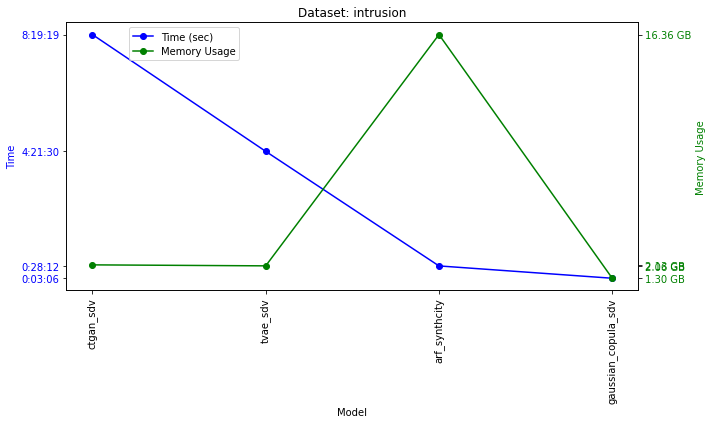

In [383]:
dataset = "intrusion"

device = ["cpu", "CPU", -99] #, "cuda", "GPU"] 


subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

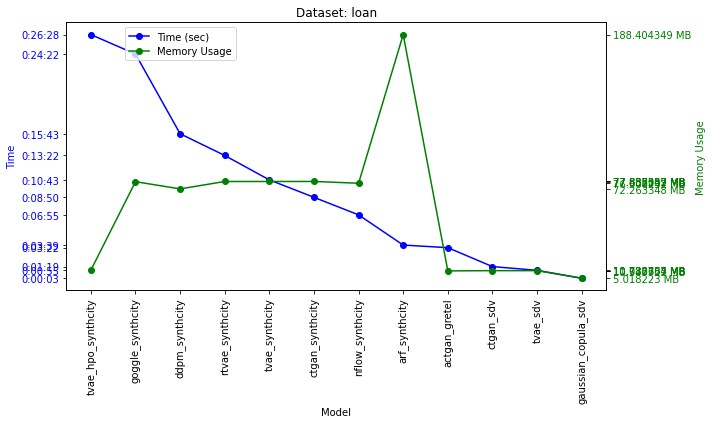

In [384]:
dataset = "loan"

device = ["cpu", "CPU", -99]

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

# CAN USE THIS GRAPH

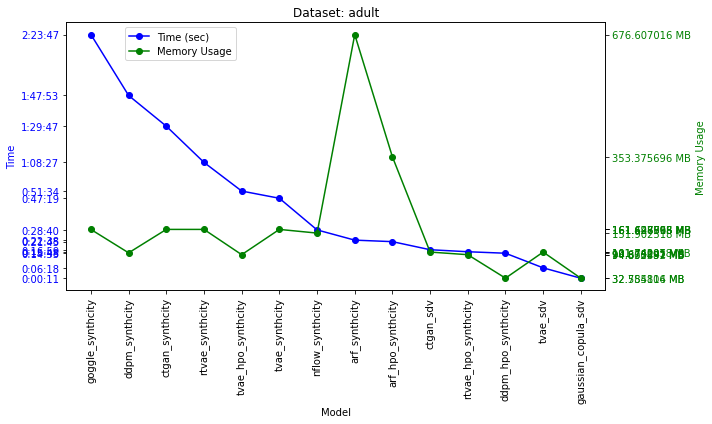

In [385]:
dataset = "adult"

device = ["cpu", "CPU", -99]

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

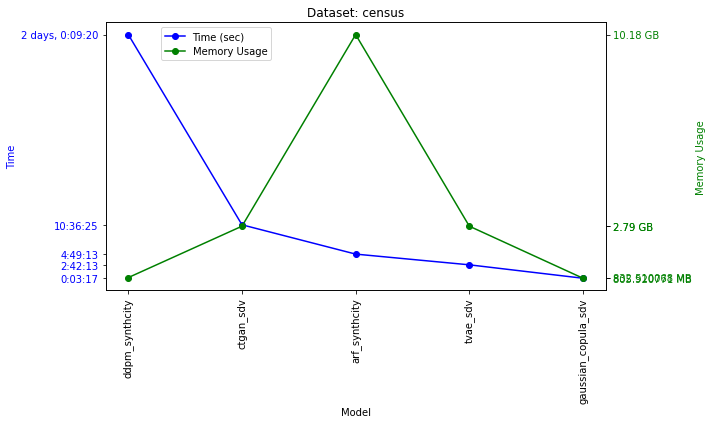

In [386]:
dataset = "census"

device = ["cpu", "CPU", -99]

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

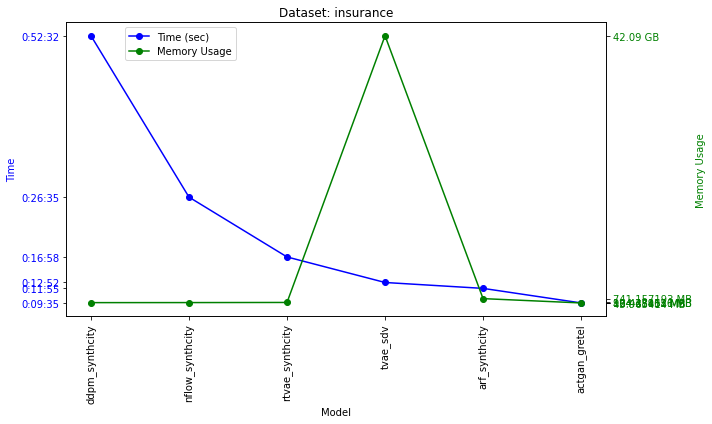

In [387]:
dataset = "insurance"

device = ["cuda", "GPU"] #["cpu", "CPU", -99]

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

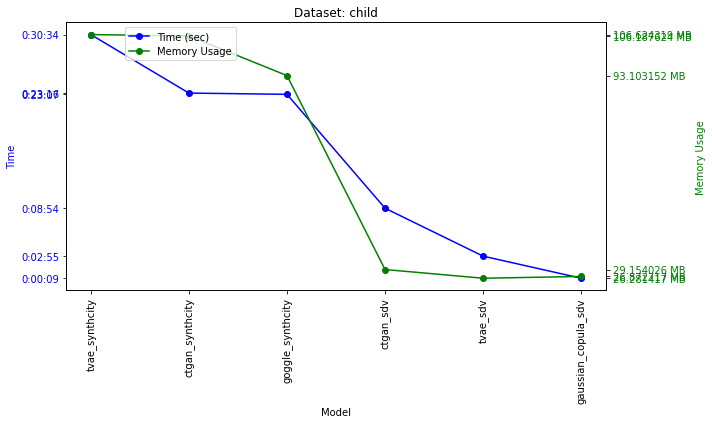

In [388]:
dataset = "child"

device = ["cpu", "CPU", -99] #

#["cpu", "CPU", -99]

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

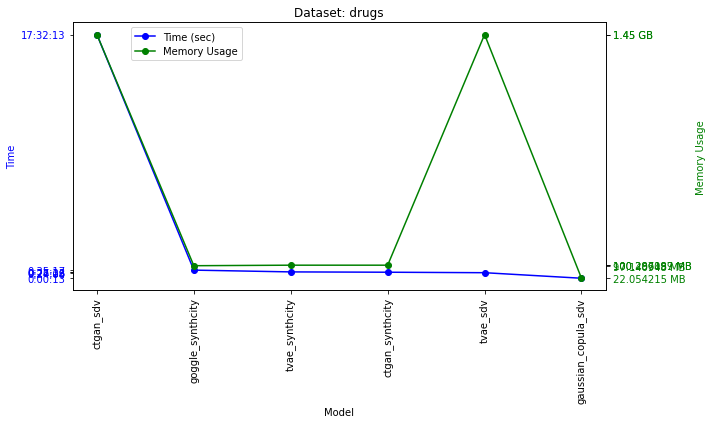

In [389]:
dataset = "drugs"

# device = ["cuda", "GPU"] 
device= ["cpu", "CPU", -99]

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(device)]

plot_line_graph(subset, dataset)

In [390]:
# dataset = "pums"

# subset = execution_scores_df.copy()
# subset = subset[(subset["dataset"] == dataset)]
# subset = subset.sort_values(by=property, ascending=False)

# subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
# subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
# subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
# subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# # subset.head(50)
# subset = subset[subset["device"].isin(["cpu", "CPU", -99])]
# # subset[subset["device"].isin(["cuda", "GPU"])]

# plot_line_graph(subset, dataset)

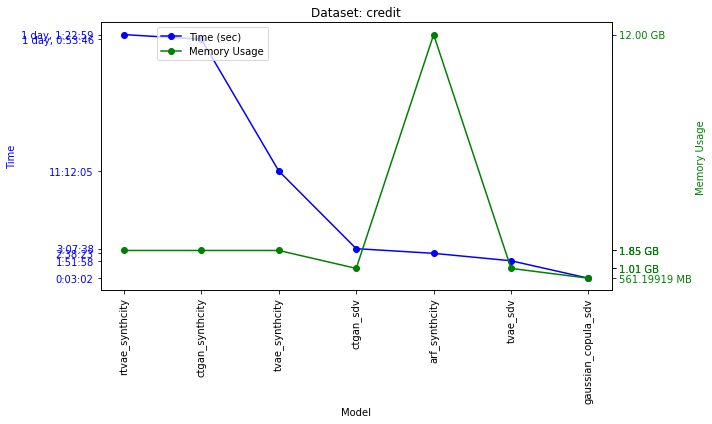

In [391]:
dataset = "credit"

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(["cpu", "CPU", -99])]
# subset[subset["device"].isin(["cuda", "GPU"])]

plot_line_graph(subset, dataset)

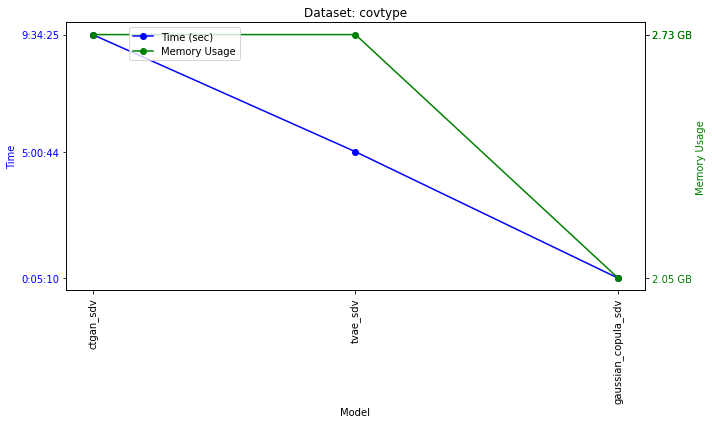

In [392]:
dataset = "covtype"

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(["cpu", "CPU", -99])]
# subset[subset["device"].isin(["cuda", "GPU"])]

plot_line_graph(subset, dataset)

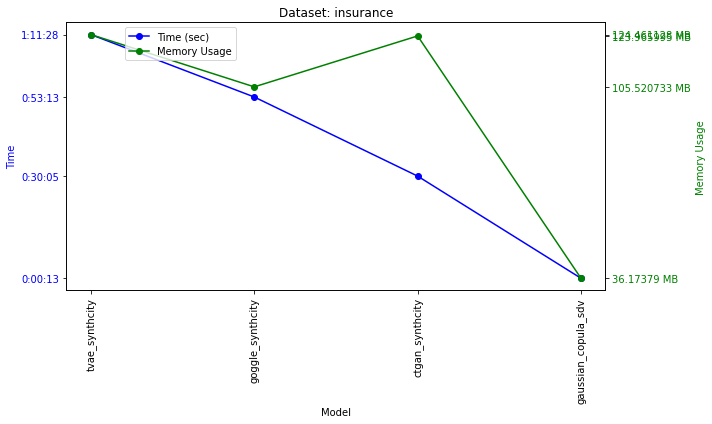

In [393]:
dataset = "insurance"

subset = execution_scores_df.copy()
subset = subset[(subset["dataset"] == dataset)]
subset = subset.sort_values(by=property, ascending=False)

subset['train_time'] = subset['train_time_sec'].apply(convert_to_timedelta)
subset['sample_time'] = subset['sample_time_sec'].apply(convert_to_timedelta)
subset['peak_memory'] = subset['peak_memory_mb'].apply(human_readable_memory)
subset['syn_size'] = subset['synthesizer_size'].apply(human_readable_memory)

# subset.head(50)
subset = subset[subset["device"].isin(["cpu", "CPU", -99])]
# subset[subset["device"].isin(["cuda", "GPU"])]

plot_line_graph(subset, dataset)

## Synthesizer size 

In [394]:
subset = execution_scores_df[(execution_scores_df["model"] == "actgan_gretel")]

In [395]:
plot_bar(subset, col_name='sdv_quality_report')

KeyError: 'sdv_quality_report'

In [124]:
execution_scores_df[execution_scores_df["device"].isin(["cuda", "GPU"])]
                    
#subset = all_df[all_df["model"].isin(["ctgan_syn", "ctgan_sdv", "actgan_gretel"])  & (all_df["case"] == "tabular") & (all_df["dataset"] == "health_insurance")]
#(35, 16)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
0,adult,GRETEL_0.20.0,actgan_gretel,26048,16,26048,GPU,300,844.420231,2.135426,112.538464,37.958943,16.898896,17.094568,3.334272,3.542528
13,adult,synthcity==0.2.9,ctgan_hpo_synthcity,26048,15,32561,cuda,300,1025.677557,0.315649,83.556384,17.983920,21.123701,16.886184,4.167808,3.334144
17,census,GRETEL_0.20.0,actgan_gretel,239428,42,239428,GPU,300,11141.097749,32.031656,3023.620889,1011.027493,519.92218,521.717176,80.447936,82.363232
23,child,GRETEL_0.20.0,actgan_gretel,16000,21,16000,GPU,300,512.057396,1.277512,33.868446,12.529515,19.87667,20.019202,2.688128,2.816
30,child,synthcity==0.2.9,arf_synthcity,16000,20,20000,cuda,0,384.656190,232.092816,534.455349,187.803084,24.865105,19.891202,3.36,2.688
31,child,synthcity==0.2.9,ddpm_synthcity,16000,20,20000,cuda,5000,2843.874894,205.397614,88.288377,5.043989,24.864581,19.891202,3.36,2.688
32,child,synthcity==0.2.9,nflow_synthcity,16000,20,20000,cuda,3000,1237.550875,2.552199,92.132051,1.373340,24.855214,19.891202,3.36,2.688
33,child,synthcity==0.2.9,rtvae_synthcity,16000,20,20000,cuda,300,762.032615,1.593081,106.565976,47.219337,24.858097,19.891202,3.36,2.688
34,covtype,GRETEL_0.20.0,actgan_gretel,464809,56,464809,GPU,300,25297.038848,70.221039,2838.488532,968.221238,208.23456,211.952904,208.23456,211.952904
38,covtype,synthcity==0.2.9,arf_synthcity,464809,55,581012,cuda,0,45131.397371,20004.786831,20945.243966,6892.086834,260.293376,208.234432,260.293376,208.234432


In [125]:
execution_scores_df[execution_scores_df["device"].isin(["cpu", "CPU", -99])]
#(73, 16)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
1,adult,SDV_1.2.1,ctgan_sdv,26048,15,32561,CPU,300,1019.838562,2.317747,101.742050,35.808308,20.880857,16.886184,3.907448,3.334144
2,adult,SDV_1.2.1,tvae_sdv,26048,15,32561,CPU,300,378.850136,0.980367,101.740078,0.417060,20.859236,16.886184,3.907448,3.334144
3,adult,SDV_1.2.1,gaussian_copula_sdv,26048,15,32561,CPU,0,11.544246,1.632146,32.554806,0.135811,20.769536,16.886184,3.907448,3.334144
4,adult,synthcity==0.2.9,ctgan_synthcity,26048,15,32561,cpu,300,5387.746336,9.032208,161.648593,38.916708,21.105475,16.886184,4.167808,3.334144
5,adult,synthcity==0.2.9,tvae_synthcity,26048,15,32561,cpu,300,2839.433315,2.598833,161.627016,44.557670,21.110107,16.886184,4.167808,3.334144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,loan,synthcity==0.2.9,ddpm_synthcity,4000,14,5000,cpu,5000,943.583055,90.133452,72.263348,3.947958,0.6,0.48,0.6,0.48
98,loan,synthcity==0.2.9,nflow_synthcity,4000,14,5000,cpu,3000,415.900657,8.077032,76.508232,2.285433,0.6,0.48,0.6,0.48
99,loan,synthcity==0.2.9,rtvae_synthcity,4000,14,5000,cpu,300,802.399064,3.425200,77.833557,29.200426,0.6,0.48,0.6,0.48
105,loan,synthcity==0.2.9,tvae_hpo_synthcity,4000,14,5000,cpu,300,1588.821771,1.105846,11.082365,41.867960,0.6,0.48,0.6,0.48


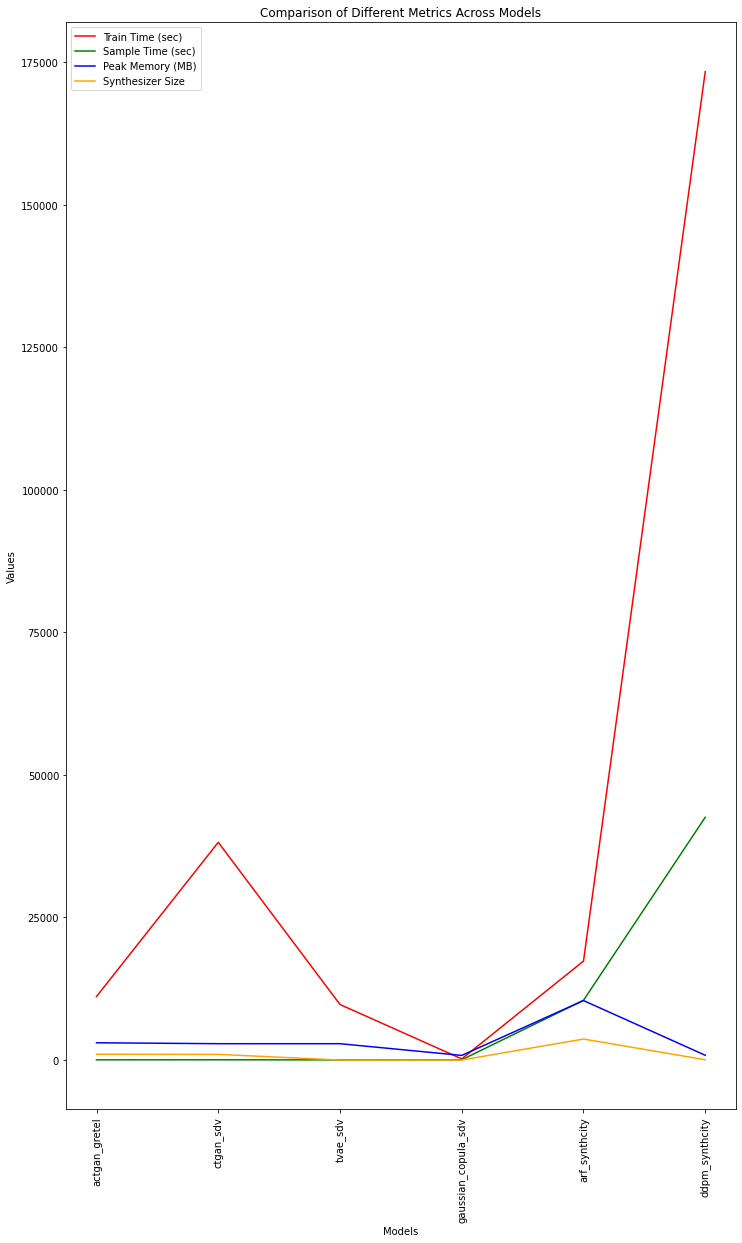

In [126]:


# Assuming df is your DataFrame and it contains the columns 'models', 'train_time_sec', 'sample_time_sec', 'peak_memory_mb', 'synthesizer_size'
# For demonstration, I'm creating a sample DataFrame. Replace this with your actual DataFrame.
# df = pd.DataFrame({
#     'models': ['Model A', 'Model B', 'Model C', 'Model D', 'Model E'],
#     'train_time_sec': [100, 150, 200, 250, 300],
#     'sample_time_sec': [10, 15, 20, 25, 30],
#     'peak_memory_mb': [500, 600, 700, 800, 900],
#     'synthesizer_size': [50, 60, 70, 80, 90]
# })

# Setting 'models' as the index
subset.set_index('model', inplace=True)

# Plotting the four line graphs in one plot with different colors
plt.figure(figsize=(12, 20))
plt.plot(subset.index, subset['train_time_sec'], label='Train Time (sec)', color='red')
plt.plot(subset.index, subset['sample_time_sec'], label='Sample Time (sec)', color='green')
plt.plot(subset.index, subset['peak_memory_mb'], label='Peak Memory (MB)', color='blue')
plt.plot(subset.index, subset['synthesizer_size'], label='Synthesizer Size', color='orange')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.title('Comparison of Different Metrics Across Models')
plt.legend()

plt.show()


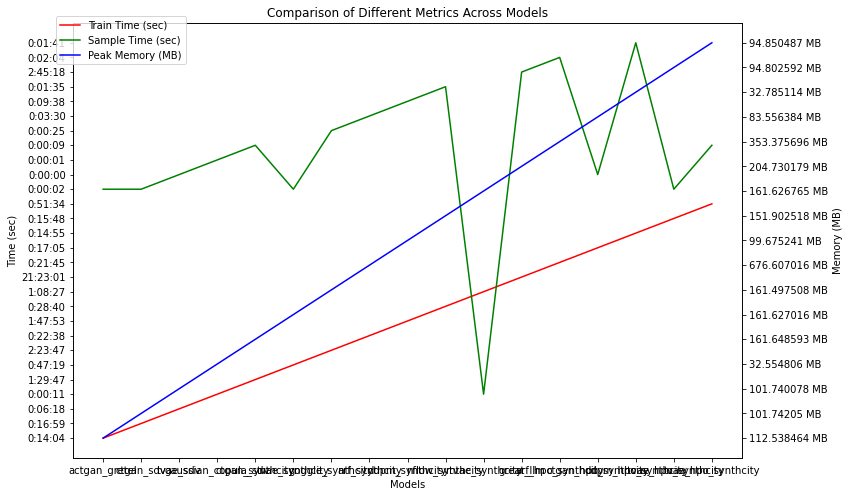

In [99]:
subset = exe_scores_rd_df[exe_scores_rd_df["dataset"] == "adult"]


# import matplotlib.pyplot as plt
# import pandas as pd

# Sample data
# subset = pd.DataFrame({
#     'models': ['Model A', 'Model B', 'Model C', 'Model D', 'Model E'],
#     'train_time_sec': [100, 150, 200, 250, 300],
#     'sample_time_sec': [10, 15, 20, 25, 30],
#     'peak_memory_mb': [500, 600, 700, 800, 900],
#     'synthesizer_size': [50, 60, 70, 80, 90]
# })

# Setting 'models' as the index
subset.set_index('model', inplace=True)

# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting the time metrics on the left y-axis
ax1.plot(subset.index, subset['train_time_sec'], label='Train Time (sec)', color='red')
ax1.plot(subset.index, subset['sample_time_sec'], label='Sample Time (sec)', color='green')
ax1.set_xlabel('Models')
ax1.set_ylabel('Time (sec)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.plot(subset.index, subset['peak_memory_mb'], label='Peak Memory (MB)', color='blue')
ax2.set_ylabel('Memory (MB)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legend
plt.title('Comparison of Different Metrics Across Models')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()

## Execution Benchmarking

In [100]:
ORANGE = "#FFB347"
GREEN = "#77dd77"
YELLOW = "#fdfd96"
def highlight_top3_min3(s, skip_cols, min_cols):
    # print(s)
    '''
    Highlight the top 3 unique numerical values in each column with different colors.
    Highlight the smallest 3 unique values in specified columns.
    Skip specified columns.
    '''
    if s.name in min_cols:
        # Find the smallest 3 unique values for specified columns
        unique_bottom_values = s.drop_duplicates().nsmallest(3)
        return [f'background-color: {GREEN}' if v == unique_bottom_values.iloc[0] else
                f'background-color: {ORANGE}' if v == unique_bottom_values.iloc[1] else
                f'background-color: {YELLOW}' if v == unique_bottom_values.iloc[2] else ''
                for v in s]
    elif s.name not in skip_cols:
        # print(s.name)
        # Find the top 3 unique values for other columns
        unique_top_values = s.drop_duplicates().nlargest(3)
        return [f'background-color: {GREEN}' if v == unique_top_values.iloc[0] else
                f'background-color: {ORANGE}' if v == unique_top_values.iloc[1] else
                f'background-color: {YELLOW}' if v == unique_top_values.iloc[2] else ''
                for v in s]
    else:
        return ['' for _ in s]  # Return empty styling for skipped columns

In [101]:
execution_scores_df.columns

Index(['dataset', 'lib', 'model', 'num_rows', 'num_cols', 'num_sampled_rows',
       'device', 'num_epochs', 'train_time_sec', 'sample_time_sec',
       'peak_memory_mb', 'synthesizer_size', 'synthetic_dataset_size_mb_deep',
       'train_dataset_size_mb_deep', 'synthetic_dataset_size_mb',
       'train_dataset_size_mb'],
      dtype='object')

In [129]:
# Define the human-readable memory conversion function
def human_readable_memory(mb):
    if mb < 1024:
        return f"{mb} MB"
    elif mb < 1024**2:
        gb = mb / 1024
        return f"{gb:.2f} GB"
    else:
        tb = mb / (1024**2)
        return f"{tb:.2f} TB"

# # # Sample DataFrame
# # data = {'MemoryInMB': [512, 2048, 30720, 1048576]}  # Example memory sizes in MB
# # df = pd.DataFrame(data)

# # Apply the function to the 'MemoryInMB' column

# print(df)

# import pandas as pd
from datetime import timedelta

# Function to convert string to timedelta
def convert_to_timedelta(time_str):
    try:
        seconds = int(time_str)
        return str(timedelta(seconds=seconds))
    except ValueError:
        # Return None or an appropriate value if conversion fails
        return None

# # Sample DataFrame
# data = {'TimeString': ['3661', '123', 'invalid', '5879']}
# df = pd.DataFrame(data)

# # Apply the function to the TimeString column
# df['ReadableTime'] = df['TimeString'].apply(convert_to_timedelta)

# print(df)

exe_scores_rd_df = execution_scores_df.copy()

exe_scores_rd_df['train_time_sec'] = exe_scores_rd_df['train_time_sec'].apply(convert_to_timedelta)
exe_scores_rd_df['sample_time_sec'] = exe_scores_rd_df['sample_time_sec'].apply(convert_to_timedelta)
exe_scores_rd_df['peak_memory_mb'] = exe_scores_rd_df['peak_memory_mb'].apply(human_readable_memory)
exe_scores_rd_df['synthesizer_size'] = exe_scores_rd_df['synthesizer_size'].apply(human_readable_memory)
exe_scores_rd_df

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
0,adult,GRETEL_0.20.0,actgan_gretel,26048,16,26048,GPU,300,0:14:04,0:00:02,112.538464 MB,37.958943 MB,16.898896,17.094568,3.334272,3.542528
1,adult,SDV_1.2.1,ctgan_sdv,26048,15,32561,CPU,300,0:16:59,0:00:02,101.74205 MB,35.808308 MB,20.880857,16.886184,3.907448,3.334144
2,adult,SDV_1.2.1,tvae_sdv,26048,15,32561,CPU,300,0:06:18,0:00:00,101.740078 MB,0.41706 MB,20.859236,16.886184,3.907448,3.334144
3,adult,SDV_1.2.1,gaussian_copula_sdv,26048,15,32561,CPU,0,0:00:11,0:00:01,32.554806 MB,0.135811 MB,20.769536,16.886184,3.907448,3.334144
4,adult,synthcity==0.2.9,ctgan_synthcity,26048,15,32561,cpu,300,1:29:47,0:00:09,161.648593 MB,38.916708 MB,21.105475,16.886184,4.167808,3.334144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,loan,synthcity==0.2.9,tvae_hpo_synthcity,4000,14,5000,cpu,300,0:26:28,0:00:01,11.082365 MB,41.86796 MB,0.6,0.48,0.6,0.48
106,pums,GRETEL_0.20.0,actgan_gretel,828161,36,828161,GPU,300,14:00:01,0:03:18,9.69 GB,3.23 GB,284.691334,291.35225,238.510496,245.135656
107,pums,SDV_1.2.1,ctgan_sdv,828161,36,-99,GPU,300,9:31:15,0:03:10,7.94 GB,2.58 GB,355.908334,291.35225,298.138304,245.135656
108,pums,SDV_1.2.1,tvae_sdv,828161,36,-99,GPU,300,6:21:27,0:02:33,7.94 GB,0.997506 MB,355.923838,291.35225,298.138304,245.135656


# Readable format Execution Scores

In [103]:
exe_scores_rd_df["model"] .unique()

array(['actgan_gretel', 'ctgan_sdv', 'tvae_sdv', 'gaussian_copula_sdv',
       'ctgan_synthcity', 'tvae_synthcity', 'goggle_synthcity',
       'arf_synthcity', 'ddpm_synthcity', 'nflow_synthcity',
       'rtvae_synthcity', 'great_llm', 'arf_hpo_synthcity',
       'ctgan_hpo_synthcity', 'ddpm_hpo_synthcity', 'rtvae_hpo_synthcity',
       'tvae_hpo_synthcity'], dtype=object)

In [104]:
exe_scores_rd_df[exe_scores_rd_df["model"] == "ddpm_syn"] #.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb


In [105]:
# synthcity seems to be resource intensive 
exe_scores_rd_df[exe_scores_rd_df["model"] == "ctgan_syn"] #.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb


In [106]:
exe_scores_rd_df[exe_scores_rd_df["model"] == "ctgan_sdv"] #.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb
1,adult,SDV_1.2.1,ctgan_sdv,26048,15,32561,CPU,300,0:16:59,0:00:02,101.74205 MB,35.808308 MB,20.880857,16.886184,3.907448,3.334144
18,census,SDV_1.2.1,ctgan_sdv,239428,41,299285,CPU,300,10:36:25,0:00:38,2.79 GB,986.504407 MB,646.948582,519.801752,98.165608,80.447808
24,child,SDV_1.2.1,ctgan_sdv,16000,20,20000,CPU,300,0:08:54,0:00:01,29.154026 MB,11.255035 MB,24.530349,19.697801,3.200128,2.688
35,covtype,SDV_1.2.1,ctgan_sdv,464809,55,581012,CPU,300,9:34:25,0:01:41,2.73 GB,868.57127 MB,255.645408,208.234432,255.645408,208.234432
42,credit,SDV_1.2.1,ctgan_sdv,227845,30,284807,CPU,300,3:07:38,0:00:18,1.01 GB,327.824054 MB,68.353808,56.50556,68.353808,56.50556
60,health_insurance,SDV_1.2.1,ctgan_sdv,1070,7,1338,CPU,300,0:00:24,0:00:00,2.309114 MB,1.107998 MB,0.293731,0.24308,0.075056,0.06848
72,intrusion,SDV_1.2.1,ctgan_sdv,395216,41,494021,CPU,300,8:19:19,0:01:12,2.13 GB,675.488391 MB,266.429332,216.029772,162.039016,132.792576
79,drugs,SDV_1.2.1,ctgan_sdv,6107,40,7634,CPU,300,17:32:13,0:00:07,1.45 GB,947.76468 MB,13.947227,10.922882,2.443008,2.003096
90,loan,SDV_1.2.1,ctgan_sdv,4000,14,5000,CPU,300,0:01:19,0:00:00,10.730754 MB,4.08813 MB,0.560128,0.48,0.560128,0.48
107,pums,SDV_1.2.1,ctgan_sdv,828161,36,-99,GPU,300,9:31:15,0:03:10,7.94 GB,2.58 GB,355.908334,291.35225,298.138304,245.135656


In [107]:
exe_scores_rd_df[exe_scores_rd_df["model"] == ""] #.head(50)

,dataset,lib,model,num_rows,num_cols,num_sampled_rows,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size,synthetic_dataset_size_mb_deep,train_dataset_size_mb_deep,synthetic_dataset_size_mb,train_dataset_size_mb


In [108]:
# exe_scores_rd_df[(exe_scores_rd_df['model'].str.contains('hpo'))] #(exe_scores_rd_df["dataset"] == "drugs") & 

In [109]:
execution_scores_df.to_csv("execution_scores.csv")

In [110]:
execution_scores_df.columns

Index(['dataset', 'lib', 'model', 'num_rows', 'num_cols', 'num_sampled_rows',
       'device', 'num_epochs', 'train_time_sec', 'sample_time_sec',
       'peak_memory_mb', 'synthesizer_size', 'synthetic_dataset_size_mb_deep',
       'train_dataset_size_mb_deep', 'synthetic_dataset_size_mb',
       'train_dataset_size_mb'],
      dtype='object')

In [111]:
skip_cols = ['dataset', 'lib', 'model', 'num_rows', 'num_cols', 'num_sampled_rows', 'device', 'synthetic_dataset_size_mb_deep',
       'train_dataset_size_mb_deep', 'synthetic_dataset_size_mb',
       'train_dataset_size_mb']

subset_df = execution_scores_df.drop(columns=['synthetic_dataset_size_mb_deep',
                                                'train_dataset_size_mb_deep',
                                                'synthetic_dataset_size_mb',
                                                'train_dataset_size_mb',
                                                'num_sampled_rows'])

In [112]:
subset = subset_df[(subset_df["dataset"] == "adult")]
min_cols = []
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,lib,model,num_rows,num_cols,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size
0,adult,GRETEL_0.20.0,actgan_gretel,26048,16,GPU,300,844.420231,2.135426,112.538464,37.958943
1,adult,SDV_1.2.1,ctgan_sdv,26048,15,CPU,300,1019.838562,2.317747,101.742050,35.808308
2,adult,SDV_1.2.1,tvae_sdv,26048,15,CPU,300,378.850136,0.980367,101.740078,0.417060
3,adult,SDV_1.2.1,gaussian_copula_sdv,26048,15,CPU,0,11.544246,1.632146,32.554806,0.135811
4,adult,synthcity==0.2.9,ctgan_synthcity,26048,15,cpu,300,5387.746336,9.032208,161.648593,38.916708
5,adult,synthcity==0.2.9,tvae_synthcity,26048,15,cpu,300,2839.433315,2.598833,161.627016,44.557670
6,adult,synthcity==0.2.9,goggle_synthcity,26048,16,cpu,300,8627.379760,25.419581,161.497508,8.131883
7,adult,synthcity==0.2.9,arf_synthcity,26048,15,cpu,0,1358.923872,210.333355,676.607016,243.196847
8,adult,synthcity==0.2.9,ddpm_synthcity,26048,15,cpu,5000,6473.861951,578.001732,99.675241,6.281305
9,adult,synthcity==0.2.9,nflow_synthcity,26048,15,cpu,3000,1720.564516,95.238318,151.902518,3.654027


In [113]:
subset = subset_df[(subset_df["dataset"] == "covtype")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,lib,model,num_rows,num_cols,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size
34,covtype,GRETEL_0.20.0,actgan_gretel,464809,56,GPU,300,25297.038848,70.221039,2838.488532,968.221238
35,covtype,SDV_1.2.1,ctgan_sdv,464809,55,CPU,300,34465.168423,101.741135,2795.060875,868.571270
36,covtype,SDV_1.2.1,tvae_sdv,464809,55,CPU,300,18044.296977,66.110085,2795.059034,1.264884
37,covtype,SDV_1.2.1,gaussian_copula_sdv,464809,55,CPU,0,310.044991,109.320973,2097.452491,0.501653
38,covtype,synthcity==0.2.9,arf_synthcity,464809,55,cuda,0,45131.397371,20004.786831,20945.243966,6892.086834
39,covtype,synthcity==0.2.9,ddpm_synthcity,464809,55,cuda,5000,118270.378157,10839.105222,2116.727556,109.720301
40,covtype,synthcity==0.2.9,rtvae_synthcity,464809,55,cuda,300,44889.613309,99.416461,3109.798841,919.328901


In [114]:
subset = subset_df[(subset_df["dataset"] == "pums")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,lib,model,num_rows,num_cols,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size
106,pums,GRETEL_0.20.0,actgan_gretel,828161,36,GPU,300,50401.469090,198.961060,9927.379896,3308.896283
107,pums,SDV_1.2.1,ctgan_sdv,828161,36,GPU,300,34275.731180,190.307225,8131.216867,2639.754827
108,pums,SDV_1.2.1,tvae_sdv,828161,36,GPU,300,22887.041172,153.788952,8131.214587,0.997506
109,pums,SDV_1.2.1,gaussian_copula_sdv,828161,36,CPU,0,691.980786,163.582960,2445.597733,0.322649


In [115]:
subset = subset_df[(subset_df["dataset"] == "drugs")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,lib,model,num_rows,num_cols,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size
78,drugs,GRETEL_0.20.0,actgan_gretel,6107,40,GPU,300,279.267477,2.136910,205.450428,83.327897
79,drugs,SDV_1.2.1,ctgan_sdv,6107,40,CPU,300,63133.236859,7.662645,1482.101211,947.764680
80,drugs,SDV_1.2.1,tvae_sdv,6107,40,CPU,300,1448.471384,1.704046,1482.099156,6.298760
81,drugs,SDV_1.2.1,gaussian_copula_sdv,6107,40,CPU,0,13.805467,1.531657,22.054215,0.568552
82,drugs,synthcity==0.2.9,ctgan_synthcity,6107,39,cpu,300,1573.181549,3.000246,100.286097,34.401091
83,drugs,synthcity==0.2.9,tvae_synthcity,6107,39,cpu,300,1656.401611,1.938672,100.297189,39.736115
84,drugs,synthcity==0.2.9,goggle_synthcity,6107,39,cpu,300,2117.021192,22.239583,97.140948,9.360272
85,drugs,synthcity==0.2.9,arf_synthcity,6107,39,cuda,0,628.581176,202.347365,384.917149,110.356191
86,drugs,synthcity==0.2.9,ddpm_synthcity,6107,39,cuda,5000,1350.116638,110.943826,84.787394,5.055033
87,drugs,synthcity==0.2.9,nflow_synthcity,6107,39,cuda,3000,466.009283,2.954708,94.918369,3.917555


In [116]:
subset = subset_df[(subset_df["dataset"] == "insurance")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,lib,model,num_rows,num_cols,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size
49,insurance,GRETEL_0.20.0,actgan_gretel,16000,28,GPU,300,575.169999,1.595064,45.965414,17.295643
50,insurance,SDV_1.2.1,tvae_sdv,16000,28,GPU,300,772.472648,39.298687,43099.608133,67.116968
51,insurance,SDV_1.2.1,gaussian_copula_sdv,16000,27,CPU,0,13.465812,1.734172,36.173790,0.235393
52,insurance,synthcity==0.2.9,ctgan_synthcity,16000,27,cpu,300,1805.528209,1.436538,123.965995,50.884597
53,insurance,synthcity==0.2.9,tvae_synthcity,16000,27,cpu,300,4288.600060,4.651339,124.461128,57.506387
54,insurance,synthcity==0.2.9,goggle_synthcity,16000,27,cpu,300,3193.426126,157.558704,105.520733,2.560964
55,insurance,synthcity==0.2.9,arf_synthcity,16000,27,cuda,0,715.619799,335.933411,741.157193,262.571478
56,insurance,synthcity==0.2.9,ddpm_synthcity,16000,27,cuda,5000,3152.624346,247.556716,96.438931,5.678757
57,insurance,synthcity==0.2.9,nflow_synthcity,16000,27,cuda,3000,1595.982682,3.312545,104.234656,1.948059
58,insurance,synthcity==0.2.9,rtvae_synthcity,16000,27,cuda,300,1018.903471,1.969418,124.471521,57.506470


In [117]:
subset = subset_df[(subset_df["dataset"] == "credit")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,lib,model,num_rows,num_cols,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size
41,credit,GRETEL_0.20.0,actgan_gretel,227845,30,GPU,300,8967.253481,22.078449,1093.606376,329.173317
42,credit,SDV_1.2.1,ctgan_sdv,227845,30,CPU,300,11258.270308,18.948731,1035.224630,327.824054
43,credit,SDV_1.2.1,tvae_sdv,227845,30,CPU,300,6718.186250,14.759176,1035.222836,0.777257
44,credit,SDV_1.2.1,gaussian_copula_sdv,227845,30,CPU,0,182.944455,24.842726,561.199190,0.266357
45,credit,synthcity==0.2.9,ctgan_synthcity,227845,30,cpu,300,89626.668572,140.276466,1897.861075,167.599348
46,credit,synthcity==0.2.9,tvae_synthcity,227845,30,cpu,300,40325.780874,54.298643,1897.842318,171.064619
47,credit,synthcity==0.2.9,arf_synthcity,227845,30,cpu,0,9503.303507,2485.023380,12287.730712,2631.409685
48,credit,synthcity==0.2.9,rtvae_synthcity,227845,30,cpu,300,91379.894162,644.339354,1897.840788,171.064624


In [118]:
subset = subset_df[(subset_df["dataset"] == "census")]
df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
df_style

,dataset,lib,model,num_rows,num_cols,device,num_epochs,train_time_sec,sample_time_sec,peak_memory_mb,synthesizer_size
17,census,GRETEL_0.20.0,actgan_gretel,239428,42,GPU,300,11141.097749,32.031656,3023.620889,1011.027493
18,census,SDV_1.2.1,ctgan_sdv,239428,41,CPU,300,38185.008448,38.364032,2861.407736,986.504407
19,census,SDV_1.2.1,tvae_sdv,239428,41,CPU,300,9733.092632,17.885139,2861.405798,0.882039
20,census,SDV_1.2.1,gaussian_copula_sdv,239428,41,CPU,0,197.487867,42.886971,805.920771,0.370677
21,census,synthcity==0.2.9,arf_synthcity,239428,41,cpu,0,17353.143302,10469.360526,10426.644256,3681.623219
22,census,synthcity==0.2.9,ddpm_synthcity,239428,41,cpu,5000,173360.587952,42572.829726,832.510068,45.317454
